<a href="https://colab.research.google.com/github/albertofernandezvillan/computer-vision-and-deep-learning-course/blob/main/closed_eyes_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" style="padding-right:10px;" src ="https://raw.githubusercontent.com/albertofernandezvillan/computer-vision-and-deep-learning-course/main/assets/university_oviedo_logo.png" width=300 px>

This notebook is from the Course "***Computer vision in the new era of Artificial Intelligence and Deep Learning***", or "*Visión por computador en la nueva era de la Inteligencia Artificial y el Deep Learning*" (ES) from the "Second quarter university extension courses" that the University of Oviedo is offering (05/04/2021 - 16/04/2021)

<[Github Repository](https://github.com/albertofernandezvillan/computer-vision-and-deep-learning-course) | [Course Web Page Information](https://www.uniovi.es/estudios/extension/cursos2c/-/asset_publisher/SEp0PJi4ISGo/content/vision-por-computador-en-la-nueva-era-de-la-inteligencia-artificial-y-el-deep-learning?redirect=%2Festudios%2Fextension%2Fcursos2c)>

# Summary

In this notebook, we are introducing a "typical" problem involving both computer vision and machine learning. In this case, the objective is to build a classifier for closed eyes detection in the wild. The features to be used by the classifier are going to be extracted using the [Histogram of Oriented Gradient (HOG) feature descriptor](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_hog.html) included in [scikit-image](https://scikit-image.org/). Moreover, in order to build the classifier, we are going to use some of the [classifiers included in scikit-learn](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning). 


# Introducing the dataset

[Closed Eyes In The Wild (CEW) dataset](http://parnec.nuaa.edu.cn/_upload/tpl/02/db/731/template731/pages/xtan/ClosedEyeDatabases.html)

They provide three versions of the dataset for you to download: 
1. Facial images in original resolution (Raw face images with background), 20M in Rar
2. Facial images in size of 100×100 (face images warped), 7.6M in Rar
3. Eye images in size of 24×24 (eye patches only), 2.6M in Rar

We are going to use the third one, as we are not interested in all the processing. In this notebook, we are only introducing a simple example in order to see how we can get the features from each image and use a scikit-learn classifier. If you are interested in all the pre-processing of the facial images (e.g. face detection, facial landmarks detection) in order to get the eye patches, [you can check this notebook](https://colab.research.google.com/github/albertofernandezvillan/dl-ml-notebooks/blob/main/face_processing.ipynb), which deals with face processing, and is also included in the repository of this course.



# Download and exploring the dataset

In [ ]:
!wget https://raw.githubusercontent.com/albertofernandezvillan/computer-vision-and-deep-learning-course/main/assets/datasets/dataset_B_Eye_Images.zip -O dataset_B_Eye_Images.zip
!unzip /content/dataset_B_Eye_Images.zip
PATH_CLOSED = "/content/dataset_B_Eye_Images/dataset_B_Eye_Images/closedLeftEyes"
PATH_OPEN = "/content/dataset_B_Eye_Images/dataset_B_Eye_Images/openLeftEyes"

## Show sample images

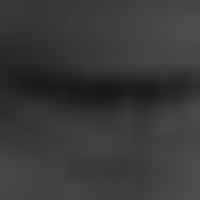

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread("/content/dataset_B_Eye_Images/dataset_B_Eye_Images/closedLeftEyes/closed_eye_0001.jpg_face_1_L.jpg")
img = cv2.resize(img, (200, 200))
cv2_imshow(img)

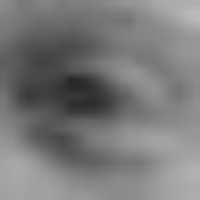

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread("/content/dataset_B_Eye_Images/dataset_B_Eye_Images/openLeftEyes/Aaron_Guiel_0001_L.jpg")
img = cv2.resize(img, (200, 200))
cv2_imshow(img)

# Show HOG descriptor

The Histogram of Oriented Gradient (HOG) feature descriptor is popular for object detection. In the following example, we compute the [HOG descriptor](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients) and display a visualisation. Briefly, HOG counts occurrences of gradient orientation in localized portions of an image.

In [ ]:
from skimage.feature import hog
from skimage import exposure

def get_hog_descriptor(image):
  # fd, hog_image = hog(image, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(1, 1), visualize=True, multichannel=True)
  fd, hog_image = hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1), visualize=True, multichannel=True)
  return fd, hog_image

In [ ]:
import cv2

img = cv2.imread("/content/dataset_B_Eye_Images/dataset_B_Eye_Images/closedLeftEyes/closed_eye_0001.jpg_face_1_L.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fd, hog_image = get_hog_descriptor(img)
print(fd.shape)

(72,)


In [ ]:
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

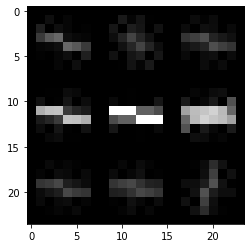

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)

(72,)


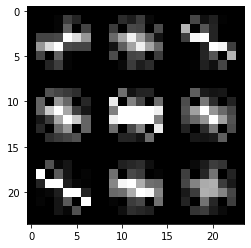

In [ ]:
img = cv2.imread("/content/dataset_B_Eye_Images/dataset_B_Eye_Images/openLeftEyes/Aaron_Guiel_0001_L.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fd, hog_image = get_hog_descriptor(img)
print(fd.shape)
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)

As we can see, the generated features for each eye patch with a size of 24x24 is composed of 72 features. We are going to use these features to build the classifier. Therefore, the key step at this point is to get the features (and the corresponding label) for each image in our dataset.

# Get the features from the images

We are going to extract the HOG features for each of both `N_OPEN` and `N_CLOSED` images. One key point here is in connection with the images that we are using:

```
PATH_CLOSED = "/content/dataset_B_Eye_Images/dataset_B_Eye_Images/closedLeftEyes"
PATH_OPEN = "/content/dataset_B_Eye_Images/dataset_B_Eye_Images/openLeftEyes"
```

Look that we are going to use only the left eye patches. Therefore, we are going to use these images for both training and testing the classifiers. We could also test the classifiers with some right eye patches in order to check if our classifier (trained only with left eye patches) is able to predict the correct class (open, closed) for right eye patches. Moreover, we can also train a "unique" classifier considering both left and right eye patches.

In this example, for the sake of simplification, we are only training and testing a classifier involving only left eye patches.




In [ ]:
import os

CLASS_OPEN = 0
CLASS_CLOSED = 1

N_OPEN = 500
N_CLOSED = 500

feature_list = []
labels = []

curr_close = 0
curr_open = 0

for filename in os.listdir(PATH_CLOSED):
  path_image = os.path.join(PATH_CLOSED, filename)
  # print(path_image)

  img = cv2.imread(path_image)
  try:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  except Exception:
    continue

  fd, hog_image = get_hog_descriptor(img)

  feature_list.append(fd)
  labels.append(CLASS_CLOSED)

  curr_close += 1

  if curr_close >= N_CLOSED:
    break;

for filename in os.listdir(PATH_OPEN):
  path_image = os.path.join(PATH_OPEN, filename)
  # print(path_image)

  img = cv2.imread(path_image)
  try:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  except Exception:
    continue
  fd, hog_image = get_hog_descriptor(img)

  feature_list.append(fd)
  labels.append(CLASS_OPEN)

  curr_open += 1

  if curr_open >= N_OPEN:
    break;

In [ ]:
import numpy as np

feature_list_np = np.array(feature_list)
labels_np = np.array(labels)

print(feature_list_np.shape)
print(labels_np.shape)

(1000, 72)
(1000,)


# Train and test a scikit-learn classifier

At this point, we can train and test a classifier using [scikit-learn](https://scikit-learn.org/stable/index.html). In this case, we are going to train and test two classifiers: a [logistic regression classifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), and also [Support Vector Machine (SVM) classifier](https://scikit-learn.org/stable/modules/svm.html).

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset for training and testing:
x_train, x_test, y_train, y_test = train_test_split(feature_list_np, labels_np, test_size=0.2, random_state=123)
print("x train shape: '{}'".format(x_train.shape))
print("x test shape: '{}'".format(x_test.shape))

x train shape: '(800, 72)'
x test shape: '(200, 72)'


In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg_model = LogisticRegression(max_iter=200)
log_reg_model.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
print(log_reg_model.score(x_train, y_train))

0.92125


In [ ]:
my_predictions = log_reg_model.predict(x_test)

In [ ]:
from sklearn.metrics import accuracy_score

print("Accuracy: '{}'".format(accuracy_score(y_test, my_predictions)))

Accuracy: '0.93'


Confusion matrix:
[[93  6]
 [ 8 93]]


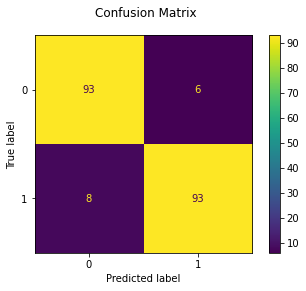

In [ ]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt


disp = metrics.plot_confusion_matrix(log_reg_model, x_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

In [ ]:
from sklearn import svm

svm_model = svm.SVC()

svm_model.fit(x_train, y_train)
print(svm_model.score(x_train, y_train))
my_predictions = svm_model.predict(x_test)
print("Accuracy: '{}'".format(accuracy_score(y_test, my_predictions)))

0.95875
Accuracy: '0.92'


Confusion matrix:
[[92  7]
 [ 9 92]]


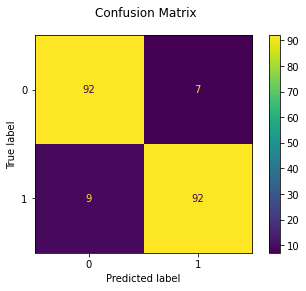

In [ ]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

disp = metrics.plot_confusion_matrix(svm_model, x_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

# Conclusions

In this notebook, we have used HOG descriptor as a feature extractor. In this sense, the [Local Binary Pattern (LBP) operator](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html) is also a powerful feature extractor that can be used to extract the features. LBP is a type of visual descriptor used for classification in computer vision. Therefore we can use (or compare the obtained results agains the HOG descriptor) this descriptor to extract the features for each eye patch, considering also the possibility to compute the [muti-block LBP (MB-LBP)](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_multiblock_local_binary_pattern.html).

Moreover, once the features for each eye patch of the dataset are extracted, we train and test two scikit-learn classifiers to build a classifier for the task of closed eyes detection in the wild.

